# Laponite Stress Relaxation

Fit one laponite relaxation curve; swap file to explore others.

**Data:** examples/data/relaxation/clays/rel_lapo_*.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rheojax.models import FractionalMaxwellModel
from rheojax.models import GeneralizedMaxwell

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.pipeline.base import Pipeline

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)

def load_tab_file(path):
    df = pd.read_csv(path, sep='	')
    df.columns = df.columns.str.strip()
    df = df.dropna()
    df.iloc[:,0] = pd.to_numeric(df.iloc[:,0], errors='coerce')
    df.iloc[:,1] = pd.to_numeric(df.iloc[:,1], errors='coerce')
    df = df.dropna()
    return df
import arviz as az


## Load multiple laponite curves

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'relaxation' / 'clays'
files = sorted(DATA_DIR.glob('rel_lapo_*.csv'))
frames = []
for f in files:
    df = load_tab_file(f)
    df['label'] = f.stem
    frames.append(df)
all_df = pd.concat(frames, ignore_index=True)
print(all_df.head())


       Time  Relaxation Modulus          label
0  0.290448          299.325342  rel_lapo_1200
1  0.591897          331.353202  rel_lapo_1200
2  0.959112          347.234241  rel_lapo_1200
3  1.420559          342.251848  rel_lapo_1200
4  1.999200          330.342952  rel_lapo_1200


## Fit one laponite curve (adjust label)

In [4]:
target = files[0]
df = load_tab_file(target)
t = df.iloc[:,0].to_numpy()
G = df.iloc[:,1].to_numpy()

gm = GeneralizedMaxwell(n_modes=5, modulus_type='tensile')
gm.fit(t, G, test_mode='relaxation', use_log_residuals=True, use_multi_start=True)
gm_pred = gm.predict(t)
gm_r2 = gm.score(t, G)

fm = FractionalMaxwellModel()
fm.fit(t, G, test_mode='relaxation', use_log_residuals=True)
fm_pred = fm.predict(t, test_mode='relaxation')
fm_r2 = r2_complex(G, fm_pred)

print({'gm_r2': gm_r2, 'fm_r2': fm_r2, 'file': target.name})


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.985809s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=12 | final_cost=751.8359 | elapsed=1.986s | final_gradient_norm=2.7190


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.402779s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=12 | final_cost=751.8359 | elapsed=0.403s | final_gradient_norm=2.7190


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.587632s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=33 | final_cost=751.8454 | elapsed=1.588s | final_gradient_norm=0.1519


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.386173s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=17 | final_cost=770.4728 | elapsed=1.386s | final_gradient_norm=8210.6166


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.288727s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=1441.4267 | elapsed=1.289s | final_gradient_norm=162.7152


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


[WARNING] Inner optimization loop hit iteration limit inner_iterations=100 | actual_reduction=-1


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.243581s


INFO:nlsq.least_squares:Convergence reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=12.6514 | elapsed=2.244s | final_gradient_norm=nan


ERROR:rheojax.utils.optimization:Failed to compute covariance from Jacobian
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 87, in compute_covariance_from_jacobian
    U, s, VT = np.linalg.svd(jac, full_matrices=False)
               ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 1862, in svd
    u, s, vh = gufunc(a, signature=signature)
               ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 172, in _raise_linalgerror_svd_nonconvergence
    raise LinAlgError("SVD did not converge")
numpy.linalg.LinAlgError: SVD did not converge


{'gm_r2': 0.9725228449975352, 'fm_r2': -33.55513176746223, 'file': 'rel_lapo_1200.csv'}


## Plot relaxation fits

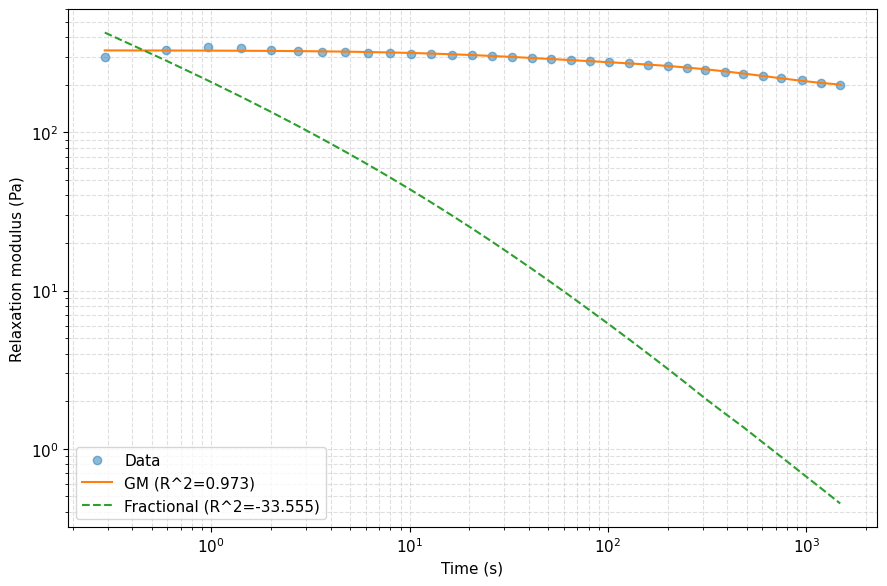

In [5]:
fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(t, G, 'o', label='Data', alpha=0.5)
ax.loglog(t, gm_pred, '-', label=f'GM (R^2={gm_r2:.3f})')
ax.loglog(t, fm_pred, '--', label=f'Fractional (R^2={fm_r2:.3f})')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Relaxation modulus (Pa)')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

In [6]:
# Helper functions for workflow
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        """Compute R² for complex-valued data."""
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot

if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        """Convert 2-column real array to complex if needed."""
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr

NUTS_CONFIG = dict(num_chains=1, num_warmup=200, num_samples=500)  # Fast demo mode


In [7]:
def _detect_datasets():
    """Auto-detect datasets from global variables."""
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': G_star, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': Gp + 1j * Gpp, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        test_mode = master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation'
        datasets.append({
            'X': master.x, 'y': master.y, 'test_mode': test_mode,
            'x_label': 'Shifted frequency', 'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({'X': t, 'y': G, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'E_t' in globals():
        datasets.append({'X': t, 'y': E_t, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'sigma' in globals():
        datasets.append({'X': t, 'y': sigma, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Stress (Pa)'})
    if 't' in globals() and 'J' in globals():
        datasets.append({'X': t, 'y': J, 'test_mode': 'creep', 'x_label': 'Time (s)', 'y_label': 'Creep compliance'})
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals, 'y': y_vals, 'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})', 'y_label': 'Stress (Pa)', 'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined.')
    return datasets

def _collect_candidate_models():
    """Collect candidate models from global variables."""
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running.')
    return models

datasets = _detect_datasets()
model_entries = _collect_candidate_models()
print(f"Found {len(datasets)} dataset(s) and {len(model_entries)} model(s)")


Found 1 dataset(s) and 2 model(s)


In [8]:
# NLSQ fitting loop - fit all models to all datasets
all_fits = {}  # {dataset_idx: [fit_records]}

for ds_idx, ds in enumerate(datasets):
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            try:
                fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
            except Exception as exc:
                print(f"Skipping {name} due to fit error: {exc}")
                continue
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue

        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue

        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue

        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    all_fits[ds_idx] = fits
    if fits:
        print(f"Dataset {ds_idx} ranking: {[(r['name'], round(r['r2'], 3)) for r in fits]}")
    else:
        print(f"Dataset {ds_idx}: No successful fits")


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.469949s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=31 | final_cost=751.8454 | elapsed=0.470s | final_gradient_norm=116.0607


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.425176s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=31 | final_cost=751.8454 | elapsed=0.425s | final_gradient_norm=116.0607


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.351617s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=770.4727 | elapsed=0.352s | final_gradient_norm=0.1683


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.677496s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=13 | final_cost=1441.4262 | elapsed=0.677s | final_gradient_norm=0.3675


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
TypeError: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Skipping gm due to predict error: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


[WARNING] Inner optimization loop hit iteration limit inner_iterations=100 | actual_reduction=-1


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.742447s


INFO:nlsq.least_squares:Convergence reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=12.6514 | elapsed=0.742s | final_gradient_norm=nan


ERROR:rheojax.utils.optimization:Failed to compute covariance from Jacobian
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 87, in compute_covariance_from_jacobian
    U, s, VT = np.linalg.svd(jac, full_matrices=False)
               ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 1862, in svd
    u, s, vh = gufunc(a, signature=signature)
               ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 172, in _raise_linalgerror_svd_nonconvergence
    raise LinAlgError("SVD did not converge")
numpy.linalg.LinAlgError: SVD did not converge


Dataset 0 ranking: [('fm', -33.555)]


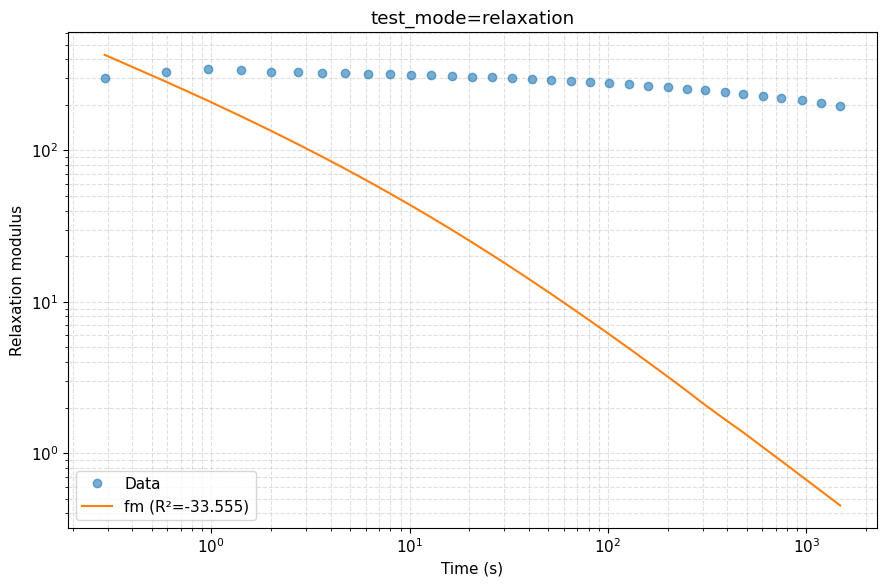

  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<05:02,  2.31it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   2%|▏         | 17/700 [00:00<00:16, 41.46it/s, 3 steps of size 1.76e-03. acc. prob=0.82]

warmup:   4%|▍         | 27/700 [00:00<00:12, 52.67it/s, 15 steps of size 3.96e-03. acc. prob=0.89]

warmup:   5%|▌         | 36/700 [00:00<00:15, 43.49it/s, 7 steps of size 4.31e-03. acc. prob=0.91] 

warmup:   6%|▌         | 43/700 [00:01<00:22, 29.24it/s, 84 steps of size 3.64e-03. acc. prob=0.92]

warmup:   7%|▋         | 48/700 [00:02<00:38, 16.86it/s, 144 steps of size 4.31e-03. acc. prob=0.92]

warmup:   7%|▋         | 52/700 [00:02<00:47, 13.72it/s, 106 steps of size 5.32e-03. acc. prob=0.93]

warmup:   8%|▊         | 55/700 [00:02<00:45, 14.03it/s, 51 steps of size 4.96e-03. acc. prob=0.93] 

warmup:   8%|▊         | 58/700 [00:02<00:46, 13.82it/s, 95 steps of size 5.45e-03. acc. prob=0.93]

warmup:   9%|▊         | 60/700 [00:03<00:45, 13.96it/s, 55 steps of size 5.82e-03. acc. prob=0.93]

warmup:   9%|▉         | 62/700 [00:03<00:49, 12.94it/s, 102 steps of size 6.49e-03. acc. prob=0.94]

warmup:   9%|▉         | 64/700 [00:03<00:53, 11.99it/s, 107 steps of size 7.21e-03. acc. prob=0.94]

warmup:   9%|▉         | 66/700 [00:03<00:48, 13.09it/s, 31 steps of size 7.86e-03. acc. prob=0.94] 

warmup:  10%|▉         | 68/700 [00:03<00:55, 11.30it/s, 142 steps of size 8.56e-03. acc. prob=0.94]

warmup:  10%|█         | 71/700 [00:04<00:47, 13.36it/s, 79 steps of size 8.42e-03. acc. prob=0.94] 

warmup:  10%|█         | 73/700 [00:04<00:44, 14.02it/s, 59 steps of size 8.74e-03. acc. prob=0.94]

warmup:  11%|█         | 76/700 [00:04<00:41, 15.07it/s, 127 steps of size 7.93e-03. acc. prob=0.94]

warmup:  11%|█         | 78/700 [00:04<00:42, 14.70it/s, 11 steps of size 7.38e-03. acc. prob=0.94] 

warmup:  12%|█▏        | 81/700 [00:04<00:40, 15.30it/s, 79 steps of size 7.56e-03. acc. prob=0.95]

warmup:  12%|█▏        | 83/700 [00:04<00:49, 12.54it/s, 133 steps of size 8.15e-03. acc. prob=0.95]

warmup:  12%|█▏        | 86/700 [00:05<00:46, 13.32it/s, 100 steps of size 8.36e-03. acc. prob=0.95]

warmup:  13%|█▎        | 88/700 [00:05<00:51, 11.83it/s, 88 steps of size 9.06e-03. acc. prob=0.95] 

warmup:  13%|█▎        | 90/700 [00:05<00:51, 11.92it/s, 95 steps of size 9.98e-03. acc. prob=0.95]

warmup:  13%|█▎        | 92/700 [00:05<00:47, 12.85it/s, 47 steps of size 1.03e-02. acc. prob=0.95]

warmup:  14%|█▎        | 95/700 [00:05<00:41, 14.56it/s, 69 steps of size 1.11e-02. acc. prob=0.95]

warmup:  14%|█▍        | 97/700 [00:05<00:39, 15.21it/s, 55 steps of size 1.14e-02. acc. prob=0.95]

warmup:  14%|█▍        | 100/700 [00:06<00:32, 18.44it/s, 31 steps of size 1.13e-02. acc. prob=0.95]

warmup:  15%|█▌        | 105/700 [00:06<00:23, 25.78it/s, 70 steps of size 1.34e-04. acc. prob=0.93]

warmup:  15%|█▌        | 108/700 [00:07<01:16,  7.79it/s, 293 steps of size 9.91e-05. acc. prob=0.93]

warmup:  16%|█▌        | 111/700 [00:08<01:57,  5.02it/s, 64 steps of size 8.67e-05. acc. prob=0.94] 

warmup:  16%|█▌        | 113/700 [00:10<03:19,  2.94it/s, 1023 steps of size 9.67e-05. acc. prob=0.94]

warmup:  16%|█▋        | 115/700 [00:11<04:00,  2.43it/s, 1023 steps of size 1.10e-04. acc. prob=0.94]

warmup:  17%|█▋        | 116/700 [00:12<04:53,  1.99it/s, 1023 steps of size 1.19e-04. acc. prob=0.94]

warmup:  17%|█▋        | 117/700 [00:13<05:48,  1.67it/s, 1023 steps of size 1.29e-04. acc. prob=0.94]

warmup:  17%|█▋        | 118/700 [00:14<06:40,  1.45it/s, 1023 steps of size 1.40e-04. acc. prob=0.94]

warmup:  17%|█▋        | 119/700 [00:15<07:25,  1.30it/s, 1023 steps of size 1.52e-04. acc. prob=0.94]

warmup:  17%|█▋        | 120/700 [00:16<08:05,  1.19it/s, 1023 steps of size 1.66e-04. acc. prob=0.94]

warmup:  17%|█▋        | 121/700 [00:17<08:28,  1.14it/s, 974 steps of size 1.80e-04. acc. prob=0.94] 

warmup:  17%|█▋        | 122/700 [00:18<08:59,  1.07it/s, 1023 steps of size 1.96e-04. acc. prob=0.94]

warmup:  18%|█▊        | 123/700 [00:19<09:17,  1.04it/s, 1023 steps of size 2.13e-04. acc. prob=0.94]

warmup:  18%|█▊        | 124/700 [00:20<09:29,  1.01it/s, 1023 steps of size 2.31e-04. acc. prob=0.94]

warmup:  18%|█▊        | 125/700 [00:21<08:14,  1.16it/s, 550 steps of size 2.49e-04. acc. prob=0.94] 

warmup:  18%|█▊        | 126/700 [00:21<06:48,  1.40it/s, 349 steps of size 2.68e-04. acc. prob=0.94]

warmup:  18%|█▊        | 127/700 [00:22<08:00,  1.19it/s, 1023 steps of size 2.90e-04. acc. prob=0.94]

warmup:  18%|█▊        | 128/700 [00:23<07:15,  1.31it/s, 475 steps of size 3.12e-04. acc. prob=0.94] 

warmup:  18%|█▊        | 129/700 [00:24<08:46,  1.08it/s, 1023 steps of size 3.37e-04. acc. prob=0.94]

warmup:  19%|█▊        | 130/700 [00:25<08:43,  1.09it/s, 851 steps of size 3.62e-04. acc. prob=0.95] 

warmup:  19%|█▊        | 131/700 [00:26<09:11,  1.03it/s, 1023 steps of size 3.90e-04. acc. prob=0.95]

warmup:  19%|█▉        | 132/700 [00:27<09:20,  1.01it/s, 1023 steps of size 4.20e-04. acc. prob=0.95]

warmup:  19%|█▉        | 133/700 [00:28<07:50,  1.21it/s, 453 steps of size 4.49e-04. acc. prob=0.95] 

warmup:  19%|█▉        | 134/700 [00:29<08:28,  1.11it/s, 1023 steps of size 4.82e-04. acc. prob=0.95]

warmup:  19%|█▉        | 135/700 [00:30<08:56,  1.05it/s, 1023 steps of size 5.16e-04. acc. prob=0.95]

warmup:  19%|█▉        | 136/700 [00:30<07:59,  1.18it/s, 595 steps of size 5.50e-04. acc. prob=0.95] 

warmup:  20%|█▉        | 137/700 [00:31<08:25,  1.11it/s, 976 steps of size 5.87e-04. acc. prob=0.95]

warmup:  20%|█▉        | 138/700 [00:32<07:20,  1.28it/s, 502 steps of size 6.24e-04. acc. prob=0.95]

warmup:  20%|█▉        | 139/700 [00:32<06:06,  1.53it/s, 343 steps of size 6.61e-04. acc. prob=0.95]

warmup:  20%|██        | 140/700 [00:33<05:26,  1.72it/s, 409 steps of size 7.01e-04. acc. prob=0.95]

warmup:  20%|██        | 141/700 [00:34<06:45,  1.38it/s, 1023 steps of size 7.46e-04. acc. prob=0.95]

warmup:  20%|██        | 142/700 [00:34<06:30,  1.43it/s, 643 steps of size 7.91e-04. acc. prob=0.95] 

warmup:  20%|██        | 143/700 [00:35<05:32,  1.68it/s, 318 steps of size 8.34e-04. acc. prob=0.95]

warmup:  21%|██        | 144/700 [00:35<04:09,  2.23it/s, 103 steps of size 8.64e-04. acc. prob=0.95]

warmup:  21%|██        | 145/700 [00:35<03:58,  2.33it/s, 386 steps of size 9.11e-04. acc. prob=0.95]

warmup:  21%|██        | 146/700 [00:36<04:12,  2.20it/s, 523 steps of size 9.61e-04. acc. prob=0.95]

warmup:  21%|██        | 148/700 [00:36<02:37,  3.49it/s, 144 steps of size 9.80e-04. acc. prob=0.95]

warmup:  21%|██▏       | 149/700 [00:36<02:32,  3.61it/s, 249 steps of size 1.03e-03. acc. prob=0.95]

warmup:  21%|██▏       | 150/700 [00:37<02:50,  3.23it/s, 387 steps of size 1.08e-03. acc. prob=0.95]

warmup:  22%|██▏       | 151/700 [00:38<04:54,  1.86it/s, 1023 steps of size 1.10e-02. acc. prob=0.95]

warmup:  22%|██▏       | 152/700 [00:38<04:05,  2.23it/s, 203 steps of size 1.12e-02. acc. prob=0.95] 

warmup:  22%|██▏       | 153/700 [00:39<06:03,  1.50it/s, 913 steps of size 1.15e-02. acc. prob=0.95]

warmup:  22%|██▏       | 154/700 [00:40<06:42,  1.36it/s, 763 steps of size 1.18e-02. acc. prob=0.95]

warmup:  22%|██▏       | 155/700 [00:40<05:35,  1.63it/s, 304 steps of size 1.21e-02. acc. prob=0.95]

warmup:  22%|██▏       | 156/700 [00:41<05:32,  1.64it/s, 562 steps of size 1.25e-02. acc. prob=0.95]

warmup:  22%|██▏       | 157/700 [00:42<06:53,  1.31it/s, 846 steps of size 1.28e-02. acc. prob=0.95]

warmup:  23%|██▎       | 158/700 [00:43<06:17,  1.44it/s, 516 steps of size 1.32e-02. acc. prob=0.95]

warmup:  23%|██▎       | 159/700 [00:43<05:01,  1.80it/s, 174 steps of size 1.34e-02. acc. prob=0.95]

warmup:  23%|██▎       | 160/700 [00:43<04:34,  1.97it/s, 396 steps of size 1.37e-02. acc. prob=0.95]

warmup:  23%|██▎       | 161/700 [00:43<03:39,  2.45it/s, 160 steps of size 1.38e-02. acc. prob=0.96]

warmup:  23%|██▎       | 163/700 [00:44<02:24,  3.73it/s, 127 steps of size 1.41e-02. acc. prob=0.96]

warmup:  23%|██▎       | 164/700 [00:44<02:02,  4.36it/s, 103 steps of size 1.41e-02. acc. prob=0.96]

warmup:  24%|██▎       | 165/700 [00:44<02:10,  4.09it/s, 270 steps of size 1.44e-02. acc. prob=0.96]

warmup:  24%|██▎       | 166/700 [00:45<02:47,  3.18it/s, 470 steps of size 1.47e-02. acc. prob=0.96]

warmup:  24%|██▍       | 167/700 [00:45<03:00,  2.95it/s, 394 steps of size 1.50e-02. acc. prob=0.96]

warmup:  24%|██▍       | 168/700 [00:45<03:17,  2.69it/s, 456 steps of size 1.53e-02. acc. prob=0.96]

warmup:  24%|██▍       | 169/700 [00:46<03:38,  2.43it/s, 511 steps of size 1.58e-02. acc. prob=0.96]

warmup:  24%|██▍       | 170/700 [00:46<03:53,  2.27it/s, 511 steps of size 1.62e-02. acc. prob=0.96]

warmup:  24%|██▍       | 171/700 [00:47<04:50,  1.82it/s, 786 steps of size 1.65e-02. acc. prob=0.96]

warmup:  25%|██▍       | 172/700 [00:47<04:04,  2.16it/s, 255 steps of size 1.70e-02. acc. prob=0.96]

warmup:  25%|██▍       | 173/700 [00:48<04:37,  1.90it/s, 654 steps of size 1.73e-02. acc. prob=0.96]

warmup:  25%|██▍       | 174/700 [00:49<04:08,  2.11it/s, 332 steps of size 1.76e-02. acc. prob=0.96]

warmup:  25%|██▌       | 175/700 [00:49<04:38,  1.88it/s, 642 steps of size 1.80e-02. acc. prob=0.96]

warmup:  25%|██▌       | 176/700 [00:49<03:56,  2.22it/s, 255 steps of size 1.82e-02. acc. prob=0.96]

warmup:  25%|██▌       | 177/700 [00:50<03:28,  2.51it/s, 264 steps of size 1.84e-02. acc. prob=0.96]

warmup:  25%|██▌       | 178/700 [00:50<03:31,  2.46it/s, 433 steps of size 1.87e-02. acc. prob=0.96]

warmup:  26%|██▌       | 179/700 [00:50<02:47,  3.12it/s, 121 steps of size 1.87e-02. acc. prob=0.96]

warmup:  26%|██▌       | 180/700 [00:51<03:08,  2.76it/s, 443 steps of size 1.90e-02. acc. prob=0.96]

warmup:  26%|██▌       | 181/700 [00:51<03:03,  2.83it/s, 330 steps of size 1.93e-02. acc. prob=0.96]

warmup:  26%|██▌       | 182/700 [00:51<02:42,  3.18it/s, 195 steps of size 1.95e-02. acc. prob=0.96]

warmup:  26%|██▌       | 183/700 [00:52<02:29,  3.45it/s, 230 steps of size 1.97e-02. acc. prob=0.96]

warmup:  26%|██▋       | 184/700 [00:52<02:00,  4.28it/s, 102 steps of size 1.96e-02. acc. prob=0.96]

warmup:  26%|██▋       | 185/700 [00:52<02:03,  4.17it/s, 189 steps of size 1.97e-02. acc. prob=0.96]

warmup:  27%|██▋       | 186/700 [00:52<02:11,  3.92it/s, 265 steps of size 2.00e-02. acc. prob=0.96]

warmup:  27%|██▋       | 187/700 [00:52<02:16,  3.77it/s, 268 steps of size 2.02e-02. acc. prob=0.96]

warmup:  27%|██▋       | 188/700 [00:53<01:51,  4.60it/s, 96 steps of size 2.00e-02. acc. prob=0.96] 

warmup:  27%|██▋       | 190/700 [00:53<01:11,  7.13it/s, 62 steps of size 1.84e-02. acc. prob=0.96]

warmup:  27%|██▋       | 192/700 [00:53<00:56,  8.99it/s, 56 steps of size 1.76e-02. acc. prob=0.96]

warmup:  28%|██▊       | 194/700 [00:53<00:46, 10.92it/s, 71 steps of size 1.64e-02. acc. prob=0.96]

warmup:  28%|██▊       | 196/700 [00:53<00:49, 10.24it/s, 14 steps of size 1.42e-02. acc. prob=0.96]

warmup:  28%|██▊       | 198/700 [00:54<01:06,  7.57it/s, 255 steps of size 1.46e-02. acc. prob=0.96]

warmup:  28%|██▊       | 199/700 [00:54<01:22,  6.08it/s, 301 steps of size 1.48e-02. acc. prob=0.96]

warmup:  29%|██▊       | 200/700 [00:54<01:22,  6.10it/s, 156 steps of size 1.69e-02. acc. prob=0.96]

sample:  29%|██▊       | 201/700 [00:55<02:01,  4.10it/s, 511 steps of size 1.69e-02. acc. prob=1.00]

sample:  29%|██▉       | 202/700 [00:55<01:51,  4.47it/s, 162 steps of size 1.69e-02. acc. prob=1.00]

sample:  29%|██▉       | 204/700 [00:55<01:17,  6.38it/s, 51 steps of size 1.69e-02. acc. prob=0.99] 

sample:  29%|██▉       | 205/700 [00:55<01:13,  6.72it/s, 110 steps of size 1.69e-02. acc. prob=0.99]

sample:  30%|██▉       | 208/700 [00:55<01:09,  7.08it/s, 315 steps of size 1.69e-02. acc. prob=0.99]

sample:  30%|██▉       | 209/700 [00:56<01:20,  6.10it/s, 233 steps of size 1.69e-02. acc. prob=0.99]

sample:  30%|███       | 210/700 [00:56<01:23,  5.90it/s, 183 steps of size 1.69e-02. acc. prob=0.99]

sample:  30%|███       | 211/700 [00:56<01:57,  4.17it/s, 453 steps of size 1.69e-02. acc. prob=0.99]

sample:  30%|███       | 212/700 [00:57<02:36,  3.12it/s, 514 steps of size 1.69e-02. acc. prob=0.99]

sample:  30%|███       | 213/700 [00:57<03:01,  2.69it/s, 511 steps of size 1.69e-02. acc. prob=0.99]

sample:  31%|███       | 214/700 [00:58<03:19,  2.43it/s, 511 steps of size 1.69e-02. acc. prob=0.99]

sample:  31%|███       | 215/700 [00:59<04:17,  1.88it/s, 791 steps of size 1.69e-02. acc. prob=0.99]

sample:  31%|███       | 216/700 [00:59<03:58,  2.03it/s, 393 steps of size 1.69e-02. acc. prob=0.99]

sample:  31%|███       | 217/700 [01:00<04:33,  1.77it/s, 727 steps of size 1.69e-02. acc. prob=0.99]

sample:  31%|███       | 218/700 [01:01<06:02,  1.33it/s, 1023 steps of size 1.69e-02. acc. prob=0.99]

sample:  31%|███▏      | 219/700 [01:02<05:26,  1.47it/s, 476 steps of size 1.69e-02. acc. prob=0.99] 

sample:  31%|███▏      | 220/700 [01:02<04:58,  1.61it/s, 477 steps of size 1.69e-02. acc. prob=0.99]

sample:  32%|███▏      | 221/700 [01:02<04:37,  1.72it/s, 453 steps of size 1.69e-02. acc. prob=0.99]

sample:  32%|███▏      | 222/700 [01:03<03:44,  2.13it/s, 193 steps of size 1.69e-02. acc. prob=0.99]

sample:  32%|███▏      | 223/700 [01:03<03:02,  2.62it/s, 170 steps of size 1.69e-02. acc. prob=0.99]

sample:  32%|███▏      | 224/700 [01:03<02:45,  2.87it/s, 255 steps of size 1.69e-02. acc. prob=0.99]

sample:  32%|███▏      | 225/700 [01:03<02:19,  3.40it/s, 157 steps of size 1.69e-02. acc. prob=0.99]

sample:  32%|███▏      | 226/700 [01:04<02:30,  3.16it/s, 328 steps of size 1.69e-02. acc. prob=0.99]

sample:  32%|███▏      | 227/700 [01:04<02:00,  3.93it/s, 97 steps of size 1.69e-02. acc. prob=0.99] 

sample:  33%|███▎      | 228/700 [01:04<01:40,  4.68it/s, 107 steps of size 1.69e-02. acc. prob=0.99]

sample:  33%|███▎      | 229/700 [01:04<01:30,  5.18it/s, 128 steps of size 1.69e-02. acc. prob=0.99]

sample:  33%|███▎      | 230/700 [01:04<01:47,  4.36it/s, 271 steps of size 1.69e-02. acc. prob=0.99]

sample:  33%|███▎      | 232/700 [01:05<01:13,  6.39it/s, 46 steps of size 1.69e-02. acc. prob=0.99] 

sample:  33%|███▎      | 234/700 [01:05<01:19,  5.90it/s, 264 steps of size 1.69e-02. acc. prob=0.99]

sample:  34%|███▎      | 235/700 [01:05<01:32,  5.02it/s, 237 steps of size 1.69e-02. acc. prob=0.99]

sample:  34%|███▎      | 236/700 [01:05<01:32,  4.99it/s, 155 steps of size 1.69e-02. acc. prob=0.99]

sample:  34%|███▍      | 237/700 [01:06<01:36,  4.78it/s, 189 steps of size 1.69e-02. acc. prob=0.99]

sample:  34%|███▍      | 238/700 [01:06<02:31,  3.05it/s, 584 steps of size 1.69e-02. acc. prob=0.99]

sample:  34%|███▍      | 239/700 [01:07<02:44,  2.81it/s, 421 steps of size 1.69e-02. acc. prob=0.99]

sample:  34%|███▍      | 240/700 [01:07<02:34,  2.98it/s, 281 steps of size 1.69e-02. acc. prob=0.99]

sample:  34%|███▍      | 241/700 [01:07<02:15,  3.39it/s, 191 steps of size 1.69e-02. acc. prob=0.99]

sample:  35%|███▍      | 242/700 [01:08<02:29,  3.07it/s, 383 steps of size 1.69e-02. acc. prob=0.99]

sample:  35%|███▍      | 243/700 [01:08<02:03,  3.71it/s, 127 steps of size 1.69e-02. acc. prob=0.99]

sample:  35%|███▍      | 244/700 [01:08<02:54,  2.62it/s, 616 steps of size 1.69e-02. acc. prob=0.99]

sample:  35%|███▌      | 245/700 [01:09<03:28,  2.18it/s, 616 steps of size 1.69e-02. acc. prob=0.99]

sample:  35%|███▌      | 246/700 [01:10<04:02,  1.87it/s, 689 steps of size 1.69e-02. acc. prob=0.99]

sample:  35%|███▌      | 247/700 [01:10<03:58,  1.90it/s, 511 steps of size 1.69e-02. acc. prob=0.99]

sample:  35%|███▌      | 248/700 [01:11<05:05,  1.48it/s, 959 steps of size 1.69e-02. acc. prob=0.99]

sample:  36%|███▌      | 249/700 [01:12<05:20,  1.41it/s, 732 steps of size 1.69e-02. acc. prob=0.99]

sample:  36%|███▌      | 250/700 [01:13<05:28,  1.37it/s, 710 steps of size 1.69e-02. acc. prob=0.99]

sample:  36%|███▌      | 251/700 [01:14<06:29,  1.15it/s, 1023 steps of size 1.69e-02. acc. prob=0.99]

sample:  36%|███▌      | 252/700 [01:14<04:50,  1.54it/s, 127 steps of size 1.69e-02. acc. prob=0.99] 

sample:  36%|███▌      | 253/700 [01:15<04:36,  1.62it/s, 511 steps of size 1.69e-02. acc. prob=0.99]

sample:  36%|███▋      | 254/700 [01:16<05:32,  1.34it/s, 797 steps of size 1.69e-02. acc. prob=0.99]

sample:  36%|███▋      | 255/700 [01:17<05:49,  1.27it/s, 728 steps of size 1.69e-02. acc. prob=0.99]

sample:  37%|███▋      | 256/700 [01:18<06:14,  1.19it/s, 946 steps of size 1.69e-02. acc. prob=0.99]

sample:  37%|███▋      | 257/700 [01:18<05:29,  1.34it/s, 511 steps of size 1.69e-02. acc. prob=1.00]

sample:  37%|███▋      | 258/700 [01:19<05:06,  1.44it/s, 511 steps of size 1.69e-02. acc. prob=1.00]

sample:  37%|███▋      | 259/700 [01:19<05:06,  1.44it/s, 624 steps of size 1.69e-02. acc. prob=1.00]

sample:  37%|███▋      | 260/700 [01:20<05:56,  1.23it/s, 1023 steps of size 1.69e-02. acc. prob=1.00]

sample:  37%|███▋      | 261/700 [01:22<06:37,  1.11it/s, 1023 steps of size 1.69e-02. acc. prob=1.00]

sample:  37%|███▋      | 262/700 [01:22<05:47,  1.26it/s, 511 steps of size 1.69e-02. acc. prob=1.00] 

sample:  38%|███▊      | 263/700 [01:23<05:33,  1.31it/s, 679 steps of size 1.69e-02. acc. prob=1.00]

sample:  38%|███▊      | 264/700 [01:24<05:35,  1.30it/s, 767 steps of size 1.69e-02. acc. prob=1.00]

sample:  38%|███▊      | 265/700 [01:24<05:48,  1.25it/s, 867 steps of size 1.69e-02. acc. prob=1.00]

sample:  38%|███▊      | 266/700 [01:25<04:22,  1.65it/s, 124 steps of size 1.69e-02. acc. prob=1.00]

sample:  38%|███▊      | 267/700 [01:25<04:11,  1.72it/s, 534 steps of size 1.69e-02. acc. prob=1.00]

sample:  38%|███▊      | 268/700 [01:26<04:31,  1.59it/s, 674 steps of size 1.69e-02. acc. prob=1.00]

sample:  38%|███▊      | 269/700 [01:26<04:24,  1.63it/s, 545 steps of size 1.69e-02. acc. prob=1.00]

sample:  39%|███▊      | 270/700 [01:28<05:25,  1.32it/s, 1022 steps of size 1.69e-02. acc. prob=1.00]

sample:  39%|███▊      | 271/700 [01:29<06:04,  1.18it/s, 1023 steps of size 1.69e-02. acc. prob=1.00]

sample:  39%|███▉      | 272/700 [01:29<04:31,  1.58it/s, 127 steps of size 1.69e-02. acc. prob=1.00] 

sample:  39%|███▉      | 273/700 [01:29<03:35,  1.98it/s, 191 steps of size 1.69e-02. acc. prob=1.00]

sample:  39%|███▉      | 274/700 [01:30<04:51,  1.46it/s, 1023 steps of size 1.69e-02. acc. prob=1.00]

sample:  39%|███▉      | 275/700 [01:31<04:58,  1.42it/s, 710 steps of size 1.69e-02. acc. prob=1.00] 

sample:  40%|███▉      | 277/700 [01:32<04:09,  1.69it/s, 816 steps of size 1.69e-02. acc. prob=1.00]

sample:  40%|███▉      | 278/700 [01:33<05:02,  1.39it/s, 913 steps of size 1.69e-02. acc. prob=1.00]

sample:  40%|███▉      | 279/700 [01:34<05:42,  1.23it/s, 883 steps of size 1.69e-02. acc. prob=1.00]

sample:  40%|████      | 280/700 [01:35<06:18,  1.11it/s, 972 steps of size 1.69e-02. acc. prob=1.00]

sample:  40%|████      | 281/700 [01:35<05:09,  1.35it/s, 312 steps of size 1.69e-02. acc. prob=1.00]

sample:  40%|████      | 282/700 [01:36<05:15,  1.33it/s, 730 steps of size 1.69e-02. acc. prob=1.00]

sample:  40%|████      | 283/700 [01:37<05:10,  1.34it/s, 726 steps of size 1.69e-02. acc. prob=1.00]

sample:  41%|████      | 284/700 [01:37<04:17,  1.62it/s, 289 steps of size 1.69e-02. acc. prob=1.00]

sample:  41%|████      | 285/700 [01:38<03:55,  1.76it/s, 407 steps of size 1.69e-02. acc. prob=1.00]

sample:  41%|████      | 286/700 [01:38<03:17,  2.10it/s, 255 steps of size 1.69e-02. acc. prob=1.00]

sample:  41%|████      | 287/700 [01:38<02:58,  2.31it/s, 306 steps of size 1.69e-02. acc. prob=1.00]

sample:  41%|████      | 288/700 [01:38<02:37,  2.62it/s, 242 steps of size 1.69e-02. acc. prob=1.00]

sample:  41%|████▏     | 289/700 [01:39<02:40,  2.56it/s, 409 steps of size 1.69e-02. acc. prob=1.00]

sample:  41%|████▏     | 290/700 [01:39<02:23,  2.85it/s, 252 steps of size 1.69e-02. acc. prob=1.00]

sample:  42%|████▏     | 291/700 [01:40<02:26,  2.79it/s, 380 steps of size 1.69e-02. acc. prob=1.00]

sample:  42%|████▏     | 292/700 [01:40<02:26,  2.78it/s, 316 steps of size 1.69e-02. acc. prob=1.00]

sample:  42%|████▏     | 293/700 [01:40<02:34,  2.64it/s, 389 steps of size 1.69e-02. acc. prob=1.00]

sample:  42%|████▏     | 295/700 [01:40<01:36,  4.20it/s, 43 steps of size 1.69e-02. acc. prob=1.00] 

sample:  42%|████▏     | 296/700 [01:41<01:25,  4.74it/s, 127 steps of size 1.69e-02. acc. prob=1.00]

sample:  42%|████▏     | 297/700 [01:41<01:19,  5.08it/s, 151 steps of size 1.69e-02. acc. prob=1.00]

sample:  43%|████▎     | 298/700 [01:41<02:03,  3.24it/s, 510 steps of size 1.69e-02. acc. prob=1.00]

sample:  43%|████▎     | 299/700 [01:42<02:01,  3.29it/s, 283 steps of size 1.69e-02. acc. prob=1.00]

sample:  43%|████▎     | 300/700 [01:42<01:42,  3.89it/s, 140 steps of size 1.69e-02. acc. prob=1.00]

sample:  43%|████▎     | 301/700 [01:42<01:29,  4.45it/s, 129 steps of size 1.69e-02. acc. prob=1.00]

sample:  43%|████▎     | 303/700 [01:42<00:59,  6.70it/s, 45 steps of size 1.69e-02. acc. prob=1.00] 

sample:  44%|████▎     | 305/700 [01:42<00:45,  8.63it/s, 63 steps of size 1.69e-02. acc. prob=1.00]

sample:  44%|████▍     | 307/700 [01:42<00:47,  8.21it/s, 179 steps of size 1.69e-02. acc. prob=1.00]

sample:  44%|████▍     | 309/700 [01:43<00:42,  9.18it/s, 31 steps of size 1.69e-02. acc. prob=1.00] 

sample:  44%|████▍     | 311/700 [01:43<00:47,  8.12it/s, 127 steps of size 1.69e-02. acc. prob=1.00]

sample:  45%|████▍     | 313/700 [01:44<01:11,  5.43it/s, 515 steps of size 1.69e-02. acc. prob=1.00]

sample:  45%|████▍     | 314/700 [01:44<01:41,  3.81it/s, 604 steps of size 1.69e-02. acc. prob=1.00]

sample:  45%|████▌     | 315/700 [01:45<01:56,  3.30it/s, 446 steps of size 1.69e-02. acc. prob=1.00]

sample:  45%|████▌     | 316/700 [01:45<01:40,  3.80it/s, 127 steps of size 1.69e-02. acc. prob=1.00]

sample:  45%|████▌     | 317/700 [01:45<02:09,  2.96it/s, 547 steps of size 1.69e-02. acc. prob=1.00]

sample:  45%|████▌     | 318/700 [01:46<02:21,  2.71it/s, 448 steps of size 1.69e-02. acc. prob=1.00]

sample:  46%|████▌     | 319/700 [01:46<02:08,  2.97it/s, 241 steps of size 1.69e-02. acc. prob=1.00]

sample:  46%|████▌     | 320/700 [01:47<02:52,  2.21it/s, 594 steps of size 1.69e-02. acc. prob=1.00]

sample:  46%|████▌     | 321/700 [01:47<02:43,  2.32it/s, 352 steps of size 1.69e-02. acc. prob=1.00]

sample:  46%|████▌     | 322/700 [01:48<02:57,  2.12it/s, 535 steps of size 1.69e-02. acc. prob=1.00]

sample:  46%|████▌     | 323/700 [01:48<02:39,  2.36it/s, 300 steps of size 1.69e-02. acc. prob=1.00]

sample:  46%|████▋     | 324/700 [01:48<02:38,  2.37it/s, 383 steps of size 1.69e-02. acc. prob=1.00]

sample:  46%|████▋     | 325/700 [01:49<03:22,  1.85it/s, 751 steps of size 1.69e-02. acc. prob=1.00]

sample:  47%|████▋     | 326/700 [01:50<03:00,  2.08it/s, 344 steps of size 1.69e-02. acc. prob=1.00]

sample:  47%|████▋     | 327/700 [01:50<02:46,  2.24it/s, 306 steps of size 1.69e-02. acc. prob=1.00]

sample:  47%|████▋     | 328/700 [01:50<02:21,  2.62it/s, 220 steps of size 1.69e-02. acc. prob=1.00]

sample:  47%|████▋     | 329/700 [01:50<01:55,  3.20it/s, 151 steps of size 1.69e-02. acc. prob=1.00]

sample:  47%|████▋     | 330/700 [01:51<02:15,  2.73it/s, 456 steps of size 1.69e-02. acc. prob=1.00]

sample:  47%|████▋     | 331/700 [01:51<02:08,  2.87it/s, 302 steps of size 1.69e-02. acc. prob=1.00]

sample:  47%|████▋     | 332/700 [01:51<02:01,  3.02it/s, 284 steps of size 1.69e-02. acc. prob=1.00]

sample:  48%|████▊     | 333/700 [01:52<01:40,  3.65it/s, 126 steps of size 1.69e-02. acc. prob=1.00]

sample:  48%|████▊     | 334/700 [01:52<01:57,  3.12it/s, 421 steps of size 1.69e-02. acc. prob=1.00]

sample:  48%|████▊     | 335/700 [01:53<02:19,  2.62it/s, 488 steps of size 1.69e-02. acc. prob=1.00]

sample:  48%|████▊     | 336/700 [01:53<02:22,  2.56it/s, 344 steps of size 1.69e-02. acc. prob=1.00]

sample:  48%|████▊     | 337/700 [01:53<02:07,  2.84it/s, 208 steps of size 1.69e-02. acc. prob=1.00]

sample:  48%|████▊     | 338/700 [01:53<01:53,  3.18it/s, 192 steps of size 1.69e-02. acc. prob=1.00]

sample:  48%|████▊     | 339/700 [01:54<02:23,  2.51it/s, 583 steps of size 1.69e-02. acc. prob=1.00]

sample:  49%|████▊     | 340/700 [01:55<03:07,  1.92it/s, 776 steps of size 1.69e-02. acc. prob=1.00]

sample:  49%|████▊     | 341/700 [01:55<02:42,  2.20it/s, 293 steps of size 1.69e-02. acc. prob=1.00]

sample:  49%|████▉     | 342/700 [01:55<02:22,  2.50it/s, 265 steps of size 1.69e-02. acc. prob=1.00]

sample:  49%|████▉     | 344/700 [01:56<01:35,  3.72it/s, 153 steps of size 1.69e-02. acc. prob=1.00]

sample:  49%|████▉     | 345/700 [01:56<01:34,  3.74it/s, 244 steps of size 1.69e-02. acc. prob=1.00]

sample:  49%|████▉     | 346/700 [01:56<01:26,  4.08it/s, 182 steps of size 1.69e-02. acc. prob=1.00]

sample:  50%|████▉     | 347/700 [01:56<01:15,  4.66it/s, 121 steps of size 1.69e-02. acc. prob=1.00]

sample:  50%|████▉     | 348/700 [01:56<01:15,  4.67it/s, 187 steps of size 1.69e-02. acc. prob=1.00]

sample:  50%|████▉     | 349/700 [01:57<01:19,  4.41it/s, 210 steps of size 1.69e-02. acc. prob=1.00]

sample:  50%|█████     | 350/700 [01:57<01:25,  4.08it/s, 255 steps of size 1.69e-02. acc. prob=1.00]

sample:  50%|█████     | 352/700 [01:58<01:39,  3.51it/s, 536 steps of size 1.69e-02. acc. prob=1.00]

sample:  50%|█████     | 353/700 [01:58<02:13,  2.60it/s, 659 steps of size 1.69e-02. acc. prob=1.00]

sample:  51%|█████     | 354/700 [01:59<03:15,  1.77it/s, 1023 steps of size 1.69e-02. acc. prob=1.00]

sample:  51%|█████     | 355/700 [02:01<04:06,  1.40it/s, 1023 steps of size 1.69e-02. acc. prob=1.00]

sample:  51%|█████     | 356/700 [02:01<03:54,  1.47it/s, 592 steps of size 1.69e-02. acc. prob=1.00] 

sample:  51%|█████     | 357/700 [02:01<03:19,  1.72it/s, 325 steps of size 1.69e-02. acc. prob=1.00]

sample:  51%|█████     | 358/700 [02:02<03:13,  1.76it/s, 519 steps of size 1.69e-02. acc. prob=1.00]

sample:  51%|█████▏    | 359/700 [02:02<02:35,  2.20it/s, 184 steps of size 1.69e-02. acc. prob=1.00]

sample:  51%|█████▏    | 360/700 [02:02<02:14,  2.52it/s, 253 steps of size 1.69e-02. acc. prob=1.00]

sample:  52%|█████▏    | 361/700 [02:03<01:46,  3.19it/s, 113 steps of size 1.69e-02. acc. prob=1.00]

sample:  52%|█████▏    | 362/700 [02:03<01:41,  3.32it/s, 264 steps of size 1.69e-02. acc. prob=1.00]

sample:  52%|█████▏    | 363/700 [02:03<02:03,  2.74it/s, 511 steps of size 1.69e-02. acc. prob=1.00]

sample:  52%|█████▏    | 364/700 [02:04<02:30,  2.23it/s, 628 steps of size 1.69e-02. acc. prob=1.00]

sample:  52%|█████▏    | 365/700 [02:04<02:36,  2.14it/s, 511 steps of size 1.69e-02. acc. prob=1.00]

sample:  52%|█████▏    | 366/700 [02:05<02:42,  2.06it/s, 521 steps of size 1.69e-02. acc. prob=1.00]

sample:  52%|█████▏    | 367/700 [02:05<02:14,  2.48it/s, 204 steps of size 1.69e-02. acc. prob=1.00]

sample:  53%|█████▎    | 368/700 [02:06<02:05,  2.65it/s, 301 steps of size 1.69e-02. acc. prob=1.00]

sample:  53%|█████▎    | 369/700 [02:06<02:16,  2.43it/s, 481 steps of size 1.69e-02. acc. prob=1.00]

sample:  53%|█████▎    | 370/700 [02:06<01:54,  2.88it/s, 193 steps of size 1.69e-02. acc. prob=1.00]

sample:  53%|█████▎    | 371/700 [02:07<01:59,  2.75it/s, 340 steps of size 1.69e-02. acc. prob=1.00]

sample:  53%|█████▎    | 373/700 [02:07<01:16,  4.28it/s, 63 steps of size 1.69e-02. acc. prob=1.00] 

sample:  53%|█████▎    | 374/700 [02:07<01:07,  4.83it/s, 110 steps of size 1.69e-02. acc. prob=1.00]

sample:  54%|█████▎    | 375/700 [02:07<01:18,  4.13it/s, 209 steps of size 1.69e-02. acc. prob=1.00]

sample:  54%|█████▎    | 376/700 [02:08<01:19,  4.06it/s, 171 steps of size 1.69e-02. acc. prob=1.00]

sample:  54%|█████▍    | 377/700 [02:08<01:35,  3.40it/s, 237 steps of size 1.69e-02. acc. prob=1.00]

sample:  54%|█████▍    | 378/700 [02:08<01:43,  3.11it/s, 301 steps of size 1.69e-02. acc. prob=1.00]

sample:  54%|█████▍    | 379/700 [02:09<02:32,  2.10it/s, 689 steps of size 1.69e-02. acc. prob=1.00]

sample:  54%|█████▍    | 380/700 [02:10<03:43,  1.43it/s, 1023 steps of size 1.69e-02. acc. prob=1.00]

sample:  54%|█████▍    | 381/700 [02:11<03:52,  1.37it/s, 797 steps of size 1.69e-02. acc. prob=1.00] 

sample:  55%|█████▍    | 382/700 [02:12<03:30,  1.51it/s, 511 steps of size 1.69e-02. acc. prob=1.00]

sample:  55%|█████▍    | 383/700 [02:12<03:39,  1.45it/s, 767 steps of size 1.69e-02. acc. prob=1.00]

sample:  55%|█████▍    | 384/700 [02:14<04:10,  1.26it/s, 1023 steps of size 1.69e-02. acc. prob=1.00]

sample:  55%|█████▌    | 385/700 [02:14<03:58,  1.32it/s, 687 steps of size 1.69e-02. acc. prob=1.00] 

sample:  55%|█████▌    | 386/700 [02:14<02:59,  1.75it/s, 127 steps of size 1.69e-02. acc. prob=1.00]

sample:  55%|█████▌    | 387/700 [02:15<03:39,  1.42it/s, 1023 steps of size 1.69e-02. acc. prob=1.00]

sample:  55%|█████▌    | 388/700 [02:16<03:20,  1.55it/s, 511 steps of size 1.69e-02. acc. prob=1.00] 

sample:  56%|█████▌    | 389/700 [02:17<03:48,  1.36it/s, 952 steps of size 1.69e-02. acc. prob=1.00]

sample:  56%|█████▌    | 390/700 [02:18<04:08,  1.25it/s, 947 steps of size 1.69e-02. acc. prob=1.00]

sample:  56%|█████▌    | 391/700 [02:18<03:25,  1.51it/s, 339 steps of size 1.69e-02. acc. prob=1.00]

sample:  56%|█████▌    | 392/700 [02:18<02:54,  1.77it/s, 339 steps of size 1.69e-02. acc. prob=1.00]

sample:  56%|█████▌    | 393/700 [02:19<02:26,  2.10it/s, 272 steps of size 1.69e-02. acc. prob=1.00]

sample:  56%|█████▋    | 395/700 [02:20<02:24,  2.11it/s, 844 steps of size 1.69e-02. acc. prob=1.00]

sample:  57%|█████▋    | 396/700 [02:20<02:25,  2.08it/s, 506 steps of size 1.69e-02. acc. prob=1.00]

sample:  57%|█████▋    | 397/700 [02:21<02:55,  1.73it/s, 847 steps of size 1.69e-02. acc. prob=1.00]

sample:  57%|█████▋    | 398/700 [02:21<02:17,  2.19it/s, 127 steps of size 1.69e-02. acc. prob=1.00]

sample:  57%|█████▋    | 399/700 [02:22<02:12,  2.27it/s, 404 steps of size 1.69e-02. acc. prob=1.00]

sample:  57%|█████▋    | 400/700 [02:22<02:28,  2.02it/s, 608 steps of size 1.69e-02. acc. prob=1.00]

sample:  57%|█████▋    | 401/700 [02:23<02:54,  1.71it/s, 749 steps of size 1.69e-02. acc. prob=1.00]

sample:  57%|█████▋    | 402/700 [02:24<03:32,  1.40it/s, 1023 steps of size 1.69e-02. acc. prob=1.00]

sample:  58%|█████▊    | 403/700 [02:24<02:50,  1.74it/s, 226 steps of size 1.69e-02. acc. prob=1.00] 

sample:  58%|█████▊    | 404/700 [02:25<02:37,  1.88it/s, 437 steps of size 1.69e-02. acc. prob=1.00]

sample:  58%|█████▊    | 405/700 [02:25<02:24,  2.04it/s, 377 steps of size 1.69e-02. acc. prob=1.00]

sample:  58%|█████▊    | 406/700 [02:25<02:12,  2.22it/s, 313 steps of size 1.69e-02. acc. prob=1.00]

sample:  58%|█████▊    | 407/700 [02:26<02:16,  2.15it/s, 483 steps of size 1.69e-02. acc. prob=1.00]

sample:  58%|█████▊    | 408/700 [02:27<02:29,  1.96it/s, 621 steps of size 1.69e-02. acc. prob=1.00]

sample:  58%|█████▊    | 409/700 [02:27<02:14,  2.16it/s, 344 steps of size 1.69e-02. acc. prob=1.00]

sample:  59%|█████▊    | 410/700 [02:27<02:24,  2.01it/s, 583 steps of size 1.69e-02. acc. prob=1.00]

sample:  59%|█████▊    | 411/700 [02:28<01:50,  2.62it/s, 112 steps of size 1.69e-02. acc. prob=1.00]

sample:  59%|█████▉    | 412/700 [02:28<01:28,  3.25it/s, 127 steps of size 1.69e-02. acc. prob=1.00]

sample:  59%|█████▉    | 413/700 [02:28<01:14,  3.86it/s, 146 steps of size 1.69e-02. acc. prob=1.00]

sample:  59%|█████▉    | 414/700 [02:28<01:01,  4.62it/s, 111 steps of size 1.69e-02. acc. prob=1.00]

sample:  60%|█████▉    | 417/700 [02:28<00:32,  8.59it/s, 57 steps of size 1.69e-02. acc. prob=1.00] 

sample:  60%|█████▉    | 419/700 [02:29<00:46,  6.05it/s, 353 steps of size 1.69e-02. acc. prob=1.00]

sample:  60%|██████    | 420/700 [02:29<00:44,  6.27it/s, 115 steps of size 1.69e-02. acc. prob=1.00]

sample:  60%|██████    | 422/700 [02:29<00:38,  7.22it/s, 120 steps of size 1.69e-02. acc. prob=1.00]

sample:  60%|██████    | 423/700 [02:29<00:41,  6.68it/s, 167 steps of size 1.69e-02. acc. prob=1.00]

sample:  61%|██████    | 424/700 [02:29<00:42,  6.53it/s, 165 steps of size 1.69e-02. acc. prob=1.00]

sample:  61%|██████    | 425/700 [02:29<00:38,  7.07it/s, 82 steps of size 1.69e-02. acc. prob=1.00] 

sample:  61%|██████    | 426/700 [02:30<00:42,  6.51it/s, 175 steps of size 1.69e-02. acc. prob=1.00]

sample:  61%|██████    | 427/700 [02:30<00:50,  5.39it/s, 268 steps of size 1.69e-02. acc. prob=1.00]

sample:  61%|██████    | 428/700 [02:30<00:48,  5.64it/s, 145 steps of size 1.69e-02. acc. prob=1.00]

sample:  61%|██████▏   | 429/700 [02:30<00:52,  5.12it/s, 240 steps of size 1.69e-02. acc. prob=1.00]

sample:  62%|██████▏   | 431/700 [02:31<00:48,  5.60it/s, 202 steps of size 1.69e-02. acc. prob=1.00]

sample:  62%|██████▏   | 432/700 [02:31<00:52,  5.08it/s, 233 steps of size 1.69e-02. acc. prob=1.00]

sample:  62%|██████▏   | 433/700 [02:31<01:03,  4.21it/s, 360 steps of size 1.69e-02. acc. prob=1.00]

sample:  62%|██████▏   | 434/700 [02:31<01:05,  4.07it/s, 255 steps of size 1.69e-02. acc. prob=1.00]

sample:  62%|██████▏   | 435/700 [02:32<00:55,  4.74it/s, 109 steps of size 1.69e-02. acc. prob=1.00]

sample:  62%|██████▏   | 437/700 [02:32<00:45,  5.83it/s, 188 steps of size 1.69e-02. acc. prob=1.00]

sample:  63%|██████▎   | 438/700 [02:32<00:44,  5.90it/s, 166 steps of size 1.69e-02. acc. prob=1.00]

sample:  63%|██████▎   | 439/700 [02:32<00:59,  4.41it/s, 377 steps of size 1.69e-02. acc. prob=1.00]

sample:  63%|██████▎   | 440/700 [02:33<01:03,  4.13it/s, 284 steps of size 1.69e-02. acc. prob=1.00]

sample:  63%|██████▎   | 442/700 [02:33<00:46,  5.59it/s, 127 steps of size 1.69e-02. acc. prob=1.00]

sample:  63%|██████▎   | 443/700 [02:33<00:42,  6.00it/s, 127 steps of size 1.69e-02. acc. prob=1.00]

sample:  63%|██████▎   | 444/700 [02:33<00:41,  6.15it/s, 146 steps of size 1.69e-02. acc. prob=1.00]

sample:  64%|██████▎   | 445/700 [02:34<01:13,  3.48it/s, 613 steps of size 1.69e-02. acc. prob=1.00]

sample:  64%|██████▎   | 446/700 [02:35<01:44,  2.42it/s, 715 steps of size 1.69e-02. acc. prob=1.00]

sample:  64%|██████▍   | 447/700 [02:35<02:03,  2.04it/s, 672 steps of size 1.69e-02. acc. prob=1.00]

sample:  64%|██████▍   | 448/700 [02:36<02:00,  2.10it/s, 440 steps of size 1.69e-02. acc. prob=1.00]

sample:  64%|██████▍   | 449/700 [02:36<02:04,  2.01it/s, 544 steps of size 1.69e-02. acc. prob=1.00]

sample:  64%|██████▍   | 450/700 [02:37<02:15,  1.85it/s, 643 steps of size 1.69e-02. acc. prob=1.00]

sample:  64%|██████▍   | 451/700 [02:37<02:22,  1.75it/s, 611 steps of size 1.69e-02. acc. prob=1.00]

sample:  65%|██████▍   | 452/700 [02:38<02:41,  1.54it/s, 815 steps of size 1.69e-02. acc. prob=1.00]

sample:  65%|██████▍   | 453/700 [02:39<02:30,  1.65it/s, 511 steps of size 1.69e-02. acc. prob=1.00]

sample:  65%|██████▍   | 454/700 [02:40<02:41,  1.52it/s, 765 steps of size 1.69e-02. acc. prob=1.00]

sample:  65%|██████▌   | 455/700 [02:40<02:33,  1.60it/s, 558 steps of size 1.69e-02. acc. prob=1.00]

sample:  65%|██████▌   | 456/700 [02:40<01:56,  2.10it/s, 124 steps of size 1.69e-02. acc. prob=1.00]

sample:  65%|██████▌   | 457/700 [02:40<01:36,  2.52it/s, 207 steps of size 1.69e-02. acc. prob=1.00]

sample:  65%|██████▌   | 458/700 [02:41<01:26,  2.80it/s, 259 steps of size 1.69e-02. acc. prob=1.00]

sample:  66%|██████▌   | 459/700 [02:41<01:39,  2.42it/s, 534 steps of size 1.69e-02. acc. prob=1.00]

sample:  66%|██████▌   | 460/700 [02:42<01:55,  2.08it/s, 650 steps of size 1.69e-02. acc. prob=1.00]

sample:  66%|██████▌   | 461/700 [02:42<02:00,  1.99it/s, 547 steps of size 1.69e-02. acc. prob=1.00]

sample:  66%|██████▌   | 462/700 [02:43<01:32,  2.56it/s, 127 steps of size 1.69e-02. acc. prob=1.00]

sample:  66%|██████▋   | 464/700 [02:43<00:56,  4.18it/s, 90 steps of size 1.69e-02. acc. prob=1.00] 

sample:  67%|██████▋   | 467/700 [02:43<00:33,  6.90it/s, 68 steps of size 1.69e-02. acc. prob=1.00]

sample:  67%|██████▋   | 469/700 [02:43<00:29,  7.90it/s, 115 steps of size 1.69e-02. acc. prob=1.00]

sample:  67%|██████▋   | 471/700 [02:43<00:23,  9.68it/s, 19 steps of size 1.69e-02. acc. prob=1.00] 

sample:  68%|██████▊   | 475/700 [02:43<00:15, 14.55it/s, 23 steps of size 1.69e-02. acc. prob=0.99]

sample:  69%|██████▉   | 483/700 [02:43<00:07, 27.26it/s, 13 steps of size 1.69e-02. acc. prob=0.99]

sample:  70%|██████▉   | 487/700 [02:44<00:19, 10.75it/s, 255 steps of size 1.69e-02. acc. prob=0.99]

sample:  70%|███████   | 490/700 [02:45<00:27,  7.67it/s, 115 steps of size 1.69e-02. acc. prob=0.99]

sample:  70%|███████   | 493/700 [02:46<00:34,  6.07it/s, 255 steps of size 1.69e-02. acc. prob=0.99]

sample:  71%|███████   | 495/700 [02:46<00:39,  5.19it/s, 255 steps of size 1.69e-02. acc. prob=0.99]

sample:  71%|███████   | 497/700 [02:47<00:39,  5.13it/s, 139 steps of size 1.69e-02. acc. prob=0.99]

sample:  71%|███████   | 498/700 [02:47<00:40,  5.00it/s, 222 steps of size 1.69e-02. acc. prob=0.99]

sample:  71%|███████▏  | 499/700 [02:47<00:37,  5.33it/s, 123 steps of size 1.69e-02. acc. prob=0.99]

sample:  72%|███████▏  | 501/700 [02:47<00:29,  6.67it/s, 65 steps of size 1.69e-02. acc. prob=0.99] 

sample:  72%|███████▏  | 503/700 [02:48<00:33,  5.94it/s, 147 steps of size 1.69e-02. acc. prob=0.99]

sample:  72%|███████▏  | 505/700 [02:48<00:31,  6.18it/s, 220 steps of size 1.69e-02. acc. prob=0.99]

sample:  72%|███████▏  | 506/700 [02:48<00:29,  6.60it/s, 100 steps of size 1.69e-02. acc. prob=0.99]

sample:  72%|███████▏  | 507/700 [02:48<00:33,  5.77it/s, 255 steps of size 1.69e-02. acc. prob=0.99]

sample:  73%|███████▎  | 508/700 [02:49<00:32,  5.98it/s, 147 steps of size 1.69e-02. acc. prob=0.99]

sample:  73%|███████▎  | 509/700 [02:49<00:28,  6.60it/s, 91 steps of size 1.69e-02. acc. prob=0.99] 

sample:  73%|███████▎  | 510/700 [02:49<00:31,  5.99it/s, 205 steps of size 1.69e-02. acc. prob=0.99]

sample:  73%|███████▎  | 511/700 [02:49<00:50,  3.71it/s, 539 steps of size 1.69e-02. acc. prob=0.99]

sample:  73%|███████▎  | 512/700 [02:50<01:06,  2.83it/s, 528 steps of size 1.69e-02. acc. prob=0.99]

sample:  73%|███████▎  | 513/700 [02:51<01:15,  2.48it/s, 517 steps of size 1.69e-02. acc. prob=0.99]

sample:  73%|███████▎  | 514/700 [02:51<01:12,  2.58it/s, 339 steps of size 1.69e-02. acc. prob=0.99]

sample:  74%|███████▎  | 515/700 [02:51<01:00,  3.06it/s, 171 steps of size 1.69e-02. acc. prob=0.99]

sample:  74%|███████▎  | 516/700 [02:51<01:04,  2.87it/s, 396 steps of size 1.69e-02. acc. prob=0.99]

sample:  74%|███████▍  | 517/700 [02:52<01:05,  2.81it/s, 362 steps of size 1.69e-02. acc. prob=0.99]

sample:  74%|███████▍  | 518/700 [02:52<01:19,  2.30it/s, 611 steps of size 1.69e-02. acc. prob=0.99]

sample:  74%|███████▍  | 519/700 [02:53<01:08,  2.63it/s, 245 steps of size 1.69e-02. acc. prob=0.99]

sample:  74%|███████▍  | 520/700 [02:53<00:54,  3.28it/s, 127 steps of size 1.69e-02. acc. prob=0.99]

sample:  74%|███████▍  | 521/700 [02:53<01:09,  2.57it/s, 553 steps of size 1.69e-02. acc. prob=0.99]

sample:  75%|███████▍  | 522/700 [02:54<00:55,  3.22it/s, 126 steps of size 1.69e-02. acc. prob=0.99]

sample:  75%|███████▍  | 523/700 [02:54<00:51,  3.43it/s, 250 steps of size 1.69e-02. acc. prob=0.99]

sample:  75%|███████▌  | 526/700 [02:54<00:26,  6.66it/s, 23 steps of size 1.69e-02. acc. prob=0.99] 

sample:  75%|███████▌  | 528/700 [02:54<00:21,  7.98it/s, 127 steps of size 1.69e-02. acc. prob=0.99]

sample:  76%|███████▌  | 530/700 [02:54<00:23,  7.24it/s, 115 steps of size 1.69e-02. acc. prob=0.99]

sample:  76%|███████▌  | 531/700 [02:55<00:22,  7.61it/s, 97 steps of size 1.69e-02. acc. prob=0.99] 

sample:  76%|███████▌  | 532/700 [02:55<00:24,  6.99it/s, 183 steps of size 1.69e-02. acc. prob=0.99]

sample:  76%|███████▌  | 533/700 [02:55<00:22,  7.41it/s, 109 steps of size 1.69e-02. acc. prob=0.99]

sample:  76%|███████▋  | 534/700 [02:55<00:23,  6.98it/s, 167 steps of size 1.69e-02. acc. prob=0.99]

sample:  76%|███████▋  | 535/700 [02:55<00:33,  4.92it/s, 358 steps of size 1.69e-02. acc. prob=0.99]

sample:  77%|███████▋  | 536/700 [02:56<00:45,  3.62it/s, 467 steps of size 1.69e-02. acc. prob=0.99]

sample:  77%|███████▋  | 537/700 [02:56<00:44,  3.67it/s, 255 steps of size 1.69e-02. acc. prob=0.99]

sample:  77%|███████▋  | 538/700 [02:56<00:49,  3.26it/s, 361 steps of size 1.69e-02. acc. prob=0.99]

sample:  77%|███████▋  | 539/700 [02:57<00:44,  3.66it/s, 188 steps of size 1.69e-02. acc. prob=0.99]

sample:  77%|███████▋  | 540/700 [02:57<00:40,  3.94it/s, 201 steps of size 1.69e-02. acc. prob=0.99]

sample:  77%|███████▋  | 542/700 [02:57<00:29,  5.44it/s, 136 steps of size 1.69e-02. acc. prob=0.99]

sample:  78%|███████▊  | 544/700 [02:58<00:36,  4.32it/s, 511 steps of size 1.69e-02. acc. prob=0.99]

sample:  78%|███████▊  | 545/700 [02:58<00:46,  3.32it/s, 544 steps of size 1.69e-02. acc. prob=0.99]

sample:  78%|███████▊  | 546/700 [02:59<00:53,  2.86it/s, 504 steps of size 1.69e-02. acc. prob=0.99]

sample:  78%|███████▊  | 547/700 [02:59<01:00,  2.55it/s, 511 steps of size 1.69e-02. acc. prob=0.99]

sample:  78%|███████▊  | 548/700 [03:00<01:10,  2.16it/s, 635 steps of size 1.69e-02. acc. prob=0.99]

sample:  78%|███████▊  | 549/700 [03:00<01:04,  2.35it/s, 315 steps of size 1.69e-02. acc. prob=0.99]

sample:  79%|███████▊  | 550/700 [03:01<01:12,  2.07it/s, 511 steps of size 1.69e-02. acc. prob=0.99]

sample:  79%|███████▊  | 551/700 [03:01<01:13,  2.02it/s, 511 steps of size 1.69e-02. acc. prob=0.99]

sample:  79%|███████▉  | 552/700 [03:02<01:09,  2.13it/s, 392 steps of size 1.69e-02. acc. prob=0.99]

sample:  79%|███████▉  | 553/700 [03:02<01:16,  1.93it/s, 653 steps of size 1.69e-02. acc. prob=0.99]

sample:  79%|███████▉  | 555/700 [03:03<00:54,  2.64it/s, 321 steps of size 1.69e-02. acc. prob=0.99]

sample:  79%|███████▉  | 556/700 [03:03<00:48,  2.97it/s, 200 steps of size 1.69e-02. acc. prob=0.99]

sample:  80%|███████▉  | 557/700 [03:03<00:48,  2.97it/s, 331 steps of size 1.69e-02. acc. prob=0.99]

sample:  80%|███████▉  | 558/700 [03:04<00:52,  2.72it/s, 447 steps of size 1.69e-02. acc. prob=0.99]

sample:  80%|███████▉  | 559/700 [03:04<00:48,  2.90it/s, 280 steps of size 1.69e-02. acc. prob=0.99]

sample:  80%|████████  | 560/700 [03:04<00:45,  3.05it/s, 289 steps of size 1.69e-02. acc. prob=0.99]

sample:  80%|████████  | 561/700 [03:05<00:40,  3.45it/s, 191 steps of size 1.69e-02. acc. prob=0.99]

sample:  80%|████████  | 563/700 [03:05<00:27,  4.92it/s, 111 steps of size 1.69e-02. acc. prob=0.99]

sample:  81%|████████  | 564/700 [03:05<00:29,  4.61it/s, 255 steps of size 1.69e-02. acc. prob=0.99]

sample:  81%|████████  | 565/700 [03:06<00:36,  3.74it/s, 406 steps of size 1.69e-02. acc. prob=0.99]

sample:  81%|████████  | 566/700 [03:06<00:30,  4.42it/s, 99 steps of size 1.69e-02. acc. prob=0.99] 

sample:  81%|████████  | 567/700 [03:06<00:32,  4.04it/s, 304 steps of size 1.69e-02. acc. prob=0.99]

sample:  81%|████████▏ | 569/700 [03:06<00:22,  5.83it/s, 63 steps of size 1.69e-02. acc. prob=0.99] 

sample:  81%|████████▏ | 570/700 [03:06<00:24,  5.36it/s, 228 steps of size 1.69e-02. acc. prob=0.99]

sample:  82%|████████▏ | 571/700 [03:06<00:21,  6.04it/s, 96 steps of size 1.69e-02. acc. prob=0.99] 

sample:  82%|████████▏ | 572/700 [03:07<00:34,  3.76it/s, 528 steps of size 1.69e-02. acc. prob=0.99]

sample:  82%|████████▏ | 573/700 [03:07<00:37,  3.35it/s, 368 steps of size 1.69e-02. acc. prob=0.99]

sample:  82%|████████▏ | 574/700 [03:08<00:36,  3.50it/s, 255 steps of size 1.69e-02. acc. prob=0.99]

sample:  82%|████████▏ | 575/700 [03:08<00:35,  3.51it/s, 273 steps of size 1.69e-02. acc. prob=0.99]

sample:  82%|████████▏ | 576/700 [03:08<00:28,  4.32it/s, 95 steps of size 1.69e-02. acc. prob=0.99] 

sample:  82%|████████▏ | 577/700 [03:08<00:27,  4.51it/s, 191 steps of size 1.69e-02. acc. prob=0.99]

sample:  83%|████████▎ | 578/700 [03:08<00:25,  4.74it/s, 180 steps of size 1.69e-02. acc. prob=0.99]

sample:  83%|████████▎ | 579/700 [03:09<00:25,  4.76it/s, 209 steps of size 1.69e-02. acc. prob=0.99]

sample:  83%|████████▎ | 580/700 [03:09<00:30,  3.95it/s, 343 steps of size 1.69e-02. acc. prob=0.99]

sample:  83%|████████▎ | 581/700 [03:09<00:36,  3.24it/s, 439 steps of size 1.69e-02. acc. prob=0.99]

sample:  83%|████████▎ | 582/700 [03:10<00:38,  3.03it/s, 369 steps of size 1.69e-02. acc. prob=0.99]

sample:  83%|████████▎ | 583/700 [03:10<00:39,  3.00it/s, 344 steps of size 1.69e-02. acc. prob=0.99]

sample:  83%|████████▎ | 584/700 [03:10<00:35,  3.28it/s, 241 steps of size 1.69e-02. acc. prob=0.99]

sample:  84%|████████▎ | 585/700 [03:11<00:41,  2.77it/s, 220 steps of size 1.69e-02. acc. prob=0.99]

sample:  84%|████████▎ | 586/700 [03:11<00:35,  3.20it/s, 188 steps of size 1.69e-02. acc. prob=0.99]

sample:  84%|████████▍ | 587/700 [03:11<00:34,  3.28it/s, 284 steps of size 1.69e-02. acc. prob=0.99]

sample:  84%|████████▍ | 589/700 [03:12<00:38,  2.92it/s, 675 steps of size 1.69e-02. acc. prob=0.99]

sample:  84%|████████▍ | 590/700 [03:12<00:39,  2.79it/s, 407 steps of size 1.69e-02. acc. prob=0.99]

sample:  84%|████████▍ | 591/700 [03:13<00:34,  3.12it/s, 212 steps of size 1.69e-02. acc. prob=0.99]

sample:  85%|████████▍ | 592/700 [03:13<00:32,  3.32it/s, 247 steps of size 1.69e-02. acc. prob=0.99]

sample:  85%|████████▍ | 593/700 [03:13<00:30,  3.46it/s, 255 steps of size 1.69e-02. acc. prob=0.99]

sample:  85%|████████▍ | 594/700 [03:14<00:33,  3.16it/s, 378 steps of size 1.69e-02. acc. prob=0.99]

sample:  85%|████████▌ | 595/700 [03:14<00:28,  3.65it/s, 168 steps of size 1.69e-02. acc. prob=0.99]

sample:  85%|████████▌ | 596/700 [03:14<00:27,  3.72it/s, 248 steps of size 1.69e-02. acc. prob=0.99]

sample:  85%|████████▌ | 597/700 [03:14<00:27,  3.76it/s, 255 steps of size 1.69e-02. acc. prob=0.99]

sample:  85%|████████▌ | 598/700 [03:14<00:22,  4.49it/s, 112 steps of size 1.69e-02. acc. prob=0.99]

sample:  86%|████████▌ | 599/700 [03:15<00:23,  4.22it/s, 272 steps of size 1.69e-02. acc. prob=0.99]

sample:  86%|████████▌ | 600/700 [03:15<00:25,  3.96it/s, 286 steps of size 1.69e-02. acc. prob=0.99]

sample:  86%|████████▋ | 605/700 [03:15<00:08, 10.58it/s, 8 steps of size 1.69e-02. acc. prob=0.99]  

sample:  87%|████████▋ | 608/700 [03:15<00:06, 13.87it/s, 72 steps of size 1.69e-02. acc. prob=0.99]

sample:  87%|████████▋ | 611/700 [03:16<00:12,  7.31it/s, 149 steps of size 1.69e-02. acc. prob=0.99]

sample:  88%|████████▊ | 613/700 [03:16<00:12,  6.98it/s, 97 steps of size 1.69e-02. acc. prob=0.99] 

sample:  88%|████████▊ | 615/700 [03:16<00:10,  8.11it/s, 87 steps of size 1.69e-02. acc. prob=0.99]

sample:  88%|████████▊ | 618/700 [03:17<00:08, 10.09it/s, 93 steps of size 1.69e-02. acc. prob=0.99]

sample:  89%|████████▊ | 620/700 [03:17<00:11,  7.12it/s, 161 steps of size 1.69e-02. acc. prob=0.99]

sample:  89%|████████▉ | 622/700 [03:17<00:10,  7.51it/s, 127 steps of size 1.69e-02. acc. prob=0.99]

sample:  89%|████████▉ | 624/700 [03:18<00:14,  5.33it/s, 79 steps of size 1.69e-02. acc. prob=0.99] 

sample:  89%|████████▉ | 625/700 [03:19<00:24,  3.05it/s, 1001 steps of size 1.69e-02. acc. prob=0.99]

sample:  89%|████████▉ | 626/700 [03:19<00:25,  2.89it/s, 426 steps of size 1.69e-02. acc. prob=0.99] 

sample:  90%|████████▉ | 627/700 [03:20<00:25,  2.85it/s, 363 steps of size 1.69e-02. acc. prob=0.99]

sample:  90%|████████▉ | 628/700 [03:20<00:23,  3.00it/s, 279 steps of size 1.69e-02. acc. prob=0.99]

sample:  90%|████████▉ | 629/700 [03:20<00:21,  3.29it/s, 221 steps of size 1.69e-02. acc. prob=0.99]

sample:  90%|█████████ | 630/700 [03:21<00:23,  2.93it/s, 455 steps of size 1.69e-02. acc. prob=0.99]

sample:  90%|█████████ | 631/700 [03:21<00:26,  2.64it/s, 480 steps of size 1.69e-02. acc. prob=0.99]

sample:  90%|█████████ | 632/700 [03:22<00:26,  2.59it/s, 404 steps of size 1.69e-02. acc. prob=0.99]

sample:  91%|█████████ | 634/700 [03:22<00:16,  3.97it/s, 110 steps of size 1.69e-02. acc. prob=0.99]

sample:  91%|█████████ | 635/700 [03:22<00:14,  4.58it/s, 111 steps of size 1.69e-02. acc. prob=0.99]

sample:  91%|█████████ | 637/700 [03:22<00:11,  5.46it/s, 162 steps of size 1.69e-02. acc. prob=0.99]

sample:  91%|█████████ | 638/700 [03:22<00:10,  5.64it/s, 152 steps of size 1.69e-02. acc. prob=0.99]

sample:  91%|█████████▏| 639/700 [03:23<00:12,  5.08it/s, 258 steps of size 1.69e-02. acc. prob=0.99]

sample:  91%|█████████▏| 640/700 [03:23<00:13,  4.39it/s, 314 steps of size 1.69e-02. acc. prob=0.99]

sample:  92%|█████████▏| 641/700 [03:23<00:12,  4.91it/s, 140 steps of size 1.69e-02. acc. prob=0.99]

sample:  92%|█████████▏| 643/700 [03:23<00:08,  6.74it/s, 55 steps of size 1.69e-02. acc. prob=0.99] 

sample:  92%|█████████▏| 644/700 [03:23<00:08,  6.76it/s, 144 steps of size 1.69e-02. acc. prob=0.99]

sample:  92%|█████████▏| 645/700 [03:23<00:07,  6.90it/s, 127 steps of size 1.69e-02. acc. prob=0.99]

sample:  92%|█████████▏| 646/700 [03:24<00:07,  7.44it/s, 96 steps of size 1.69e-02. acc. prob=0.99] 

sample:  92%|█████████▏| 647/700 [03:24<00:11,  4.56it/s, 441 steps of size 1.69e-02. acc. prob=0.99]

sample:  93%|█████████▎| 648/700 [03:25<00:15,  3.28it/s, 511 steps of size 1.69e-02. acc. prob=0.99]

sample:  93%|█████████▎| 649/700 [03:25<00:21,  2.42it/s, 677 steps of size 1.69e-02. acc. prob=0.99]

sample:  93%|█████████▎| 650/700 [03:26<00:21,  2.27it/s, 504 steps of size 1.69e-02. acc. prob=0.99]

sample:  93%|█████████▎| 651/700 [03:26<00:18,  2.67it/s, 206 steps of size 1.69e-02. acc. prob=0.99]

sample:  93%|█████████▎| 653/700 [03:26<00:14,  3.20it/s, 410 steps of size 1.69e-02. acc. prob=0.99]

sample:  93%|█████████▎| 654/700 [03:27<00:15,  2.92it/s, 434 steps of size 1.69e-02. acc. prob=0.99]

sample:  94%|█████████▎| 655/700 [03:27<00:12,  3.47it/s, 127 steps of size 1.69e-02. acc. prob=0.99]

sample:  94%|█████████▎| 656/700 [03:27<00:11,  3.81it/s, 193 steps of size 1.69e-02. acc. prob=0.99]

sample:  94%|█████████▍| 657/700 [03:27<00:11,  3.69it/s, 287 steps of size 1.69e-02. acc. prob=0.99]

sample:  94%|█████████▍| 658/700 [03:28<00:10,  3.86it/s, 228 steps of size 1.69e-02. acc. prob=0.99]

sample:  94%|█████████▍| 659/700 [03:28<00:12,  3.28it/s, 419 steps of size 1.69e-02. acc. prob=0.99]

sample:  94%|█████████▍| 660/700 [03:29<00:14,  2.71it/s, 511 steps of size 1.69e-02. acc. prob=0.99]

sample:  94%|█████████▍| 661/700 [03:29<00:16,  2.38it/s, 533 steps of size 1.69e-02. acc. prob=0.99]

sample:  95%|█████████▍| 662/700 [03:30<00:15,  2.48it/s, 371 steps of size 1.69e-02. acc. prob=0.99]

sample:  95%|█████████▍| 663/700 [03:30<00:13,  2.79it/s, 255 steps of size 1.69e-02. acc. prob=0.99]

sample:  95%|█████████▍| 664/700 [03:30<00:15,  2.37it/s, 576 steps of size 1.69e-02. acc. prob=0.99]

sample:  95%|█████████▌| 665/700 [03:31<00:16,  2.07it/s, 571 steps of size 1.69e-02. acc. prob=0.99]

sample:  95%|█████████▌| 666/700 [03:31<00:12,  2.67it/s, 122 steps of size 1.69e-02. acc. prob=0.99]

sample:  95%|█████████▌| 667/700 [03:31<00:11,  2.81it/s, 265 steps of size 1.69e-02. acc. prob=0.99]

sample:  96%|█████████▌| 669/700 [03:32<00:08,  3.85it/s, 212 steps of size 1.69e-02. acc. prob=0.99]

sample:  96%|█████████▌| 671/700 [03:32<00:05,  5.41it/s, 103 steps of size 1.69e-02. acc. prob=0.99]

sample:  96%|█████████▌| 672/700 [03:32<00:04,  5.78it/s, 115 steps of size 1.69e-02. acc. prob=0.99]

sample:  97%|█████████▋| 678/700 [03:32<00:01, 14.02it/s, 22 steps of size 1.69e-02. acc. prob=0.99] 

sample:  97%|█████████▋| 681/700 [03:32<00:01, 15.73it/s, 65 steps of size 1.69e-02. acc. prob=0.99]

sample:  98%|█████████▊| 684/700 [03:33<00:01,  8.27it/s, 352 steps of size 1.69e-02. acc. prob=0.99]

sample:  98%|█████████▊| 686/700 [03:33<00:01,  7.08it/s, 161 steps of size 1.69e-02. acc. prob=0.99]

sample:  98%|█████████▊| 688/700 [03:34<00:02,  5.66it/s, 280 steps of size 1.69e-02. acc. prob=0.99]

sample:  99%|█████████▊| 690/700 [03:34<00:01,  6.54it/s, 93 steps of size 1.69e-02. acc. prob=0.99] 

sample:  99%|█████████▉| 692/700 [03:35<00:01,  6.28it/s, 124 steps of size 1.69e-02. acc. prob=0.99]

sample:  99%|█████████▉| 694/700 [03:35<00:00,  7.76it/s, 35 steps of size 1.69e-02. acc. prob=0.99] 

sample: 100%|██████████| 700/700 [03:35<00:00,  3.25it/s, 2 steps of size 1.69e-02. acc. prob=0.98] 

Dataset 0: Bayesian inference complete for fm


In [9]:
# Bayesian inference on best model per dataset
def _plot_data_and_fits(ds, fits):
    """Plot data with model fits overlay."""
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot, y_true = ds['X'], ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        ax.loglog(X_plot, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(X_plot, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)

bayes_results = {}  # {dataset_idx: inference_data}

for ds_idx, ds in enumerate(datasets):
    fits = all_fits.get(ds_idx, [])
    if not fits:
        continue

    best = fits[0]
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'], ds['y'], **NUTS_CONFIG, test_mode=ds['test_mode'],
        )
        bayes_results[ds_idx] = bayes_result.to_inference_data()
        print(f"Dataset {ds_idx}: Bayesian inference complete for {best['name']}")
    except Exception as exc:
        print(f"Dataset {ds_idx}: Bayesian step failed for {best['name']}: {exc}")


In [10]:
# ArviZ diagnostics for Bayesian results
def _plot_diagnostics(idata):
    """Generate ArviZ diagnostic plots."""
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
            plt.tight_layout()
            display(obj)
            plt.close('all')
        except Exception as exc:
            print(f"Skipping {name} plot: {exc}")

for ds_idx, idata in bayes_results.items():
    print(f"\n--- Diagnostics for dataset {ds_idx} ---")
    _plot_diagnostics(idata)



--- Diagnostics for dataset 0 ---


array([[<Axes: ylabel='beta'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='c1'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='alpha', ylabel='tau'>, <Axes: xlabel='beta'>,
        <Axes: xlabel='c1'>, <Axes: xlabel='sigma'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'alpha\n0'}>,
        <Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'c1\n0'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'tau\n0'}>, <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'c1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'c1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: >]], dtype=object)